# Table of Contents | ASD DATA 

- [The BREAST-CANCER dataset](#The-BREAST-CANCER-dataset):
    - [Load the dataset](#Load-the-Dataset)
    - [Explore the dataset: Descriptive statistics](#Explore-the-dataset:-Descriptive-statistics)
    - [Explore the dataset: Visualization](#Explore-the-dataset:-Visualization)
    



The entire project has been based on the following study [Investigating the Correspondence of Clinical  Diagnostic Grouping With Underlying Neurobiological and Phenotypic Clusters Using Unsupervised Machine Learning](https://doi.org/10.1016/j.dib.2018.01.080).

The work focuses on two different pathologies in brain disorders: ASD and ADHD

## The ASD dataset

available at [ABIDE I database](https://fcon_1000.projects.nitrc.org/indi/abide/abide_I.html).


This is .......
 
This data set includes 286 intances (201 of one class, 85 of another class).  The instances are described by 9 attributes, some of which are ordinal and some are nominal.
 
Attribute information

| column | values |
| --- | --- |
| Class | no-recurrence-events, recurrence-events |
| age | 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99|
| menopause | lt40, ge40, premeno|
| tumor-size | 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59|
| inv-nodes | 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39|
| node-caps | yes, no|
| deg-malig | 1, 2, 3|
| breast | left, right|
| breast-quad | left-up, left-low, right-up, right-low, central|
| irradiat | yes, no|
 
There are 9 Missing Attribute Values (denoted by "?") 


In [41]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt #for the plots
import seaborn as sns 

We start opening the dataset. 

pd. We know from  the datasheets of the dataset provided by ABIDE which are the ranges of the categories and we noted that there are some values in the data categorized as -9999, which is a way to denoted missing data or values out of range, so we are going to consider them as NaN.

In [42]:
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD','ASD_phenotypic.csv'), na_values='-9999')


In [43]:
#restituiamo il percorso completo del nostro file
ASD_phenotypic = pd.read_csv(os.path.join('Datasets','Phenotypic Datasets','ASD','ASD_phenotypic.csv'),na_values = '-9999')
#contiamo questi errori di registrazione 
errors = '-9999'
#dizionario per memorizzare risultati per ogni colonna
errors_per_feature = {}
#Iterazione su tutte le colonne
for col in ASD_phenotypic.columns:
    # Conta i valori nella colonna e memorizza il risultato nel dizionario
    errors_per_feature[col] = (ASD_phenotypic[col] == errors).sum()

# Stampa i risultati
for col, conteggio in errors_per_feature.items():
    print(f"Numero di elementi con valore '{errors}' nella colonna '{col}': {conteggio}")

Numero di elementi con valore '-9999' nella colonna 'SITE_ID': 0
Numero di elementi con valore '-9999' nella colonna 'SUB_ID': 0
Numero di elementi con valore '-9999' nella colonna 'DX_GROUP': 0
Numero di elementi con valore '-9999' nella colonna 'DSM_IV_TR': 0
Numero di elementi con valore '-9999' nella colonna 'AGE_AT_SCAN': 0
Numero di elementi con valore '-9999' nella colonna 'SEX': 0
Numero di elementi con valore '-9999' nella colonna 'HANDEDNESS_CATEGORY': 0
Numero di elementi con valore '-9999' nella colonna 'HANDEDNESS_SCORES': 0
Numero di elementi con valore '-9999' nella colonna 'FIQ': 0
Numero di elementi con valore '-9999' nella colonna 'VIQ': 0
Numero di elementi con valore '-9999' nella colonna 'PIQ': 0
Numero di elementi con valore '-9999' nella colonna 'FIQ_TEST_TYPE': 0
Numero di elementi con valore '-9999' nella colonna 'VIQ_TEST_TYPE': 0
Numero di elementi con valore '-9999' nella colonna 'PIQ_TEST_TYPE': 0
Numero di elementi con valore '-9999' nella colonna 'ADI_R_S

In [44]:
#visualizziamo, non completamente, il nostro dataset
#e otteniamone la dimensione: prima info utile
ASD_phenotypic

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
0,CALTECH,51456,1,4.0,55.40,...,NaN,NaN,2,NaN,NaN
1,CALTECH,51457,1,4.0,22.90,...,NaN,NaN,2,NaN,NaN
2,CALTECH,51458,1,1.0,39.20,...,NaN,NaN,2,NaN,NaN
3,CALTECH,51459,1,1.0,22.80,...,NaN,NaN,2,NaN,NaN
4,CALTECH,51460,1,1.0,34.60,...,NaN,NaN,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1107,YALE,50624,1,3.0,11.08,...,NaN,NaN,1,NaN,NaN
1108,YALE,50625,1,3.0,7.00,...,NaN,NaN,1,NaN,NaN
1109,YALE,50626,1,3.0,11.08,...,NaN,NaN,1,NaN,NaN
1110,YALE,50627,1,3.0,9.50,...,NaN,NaN,1,NaN,NaN


##  CATEGORICAL EXPLORATION

In [45]:
#otteniamo le informazioni relative al dataset
ASD_phenotypic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 74 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SITE_ID                          1112 non-null   object 
 1   SUB_ID                           1112 non-null   int64  
 2   DX_GROUP                         1112 non-null   int64  
 3   DSM_IV_TR                        1040 non-null   float64
 4   AGE_AT_SCAN                      1112 non-null   float64
 5   SEX                              1112 non-null   int64  
 6   HANDEDNESS_CATEGORY              786 non-null    object 
 7   HANDEDNESS_SCORES                364 non-null    float64
 8   FIQ                              1040 non-null   float64
 9   VIQ                              917 non-null    float64
 10  PIQ                              931 non-null    float64
 11  FIQ_TEST_TYPE                    943 non-null    object 
 12  VIQ_TEST_TYPE       

In [46]:
#guardando il database, si è notata una colonna con più di un valore separati da ; -> controllo per capire se vengono letti tutti 
#medname = ASD_phenotypic['MEDICATION_NAME']
#medname

In [47]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

#medname

In [48]:
#vogliamo individuare e capire cosa sono questi object
objects = ASD_phenotypic.select_dtypes(include=['object'])
objects

,SITE_ID,HANDEDNESS_CATEGORY,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,COMORBIDITY,CURRENT_MED_STATUS,MEDICATION_NAME
0,CALTECH,R,WASI,WASI,WASI,NaN,NaN,NaN
1,CALTECH,Ambi,WASI,WASI,WASI,NaN,NaN,NaN
2,CALTECH,R,WASI,WASI,WASI,NaN,NaN,NaN
3,CALTECH,R,WASI,WASI,WASI,NaN,NaN,NaN
4,CALTECH,Ambi,WASI,WASI,WASI,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1107,YALE,R,DAS_II_SA,DAS_II_SA,DAS_II_SA,NaN,NaN,NaN
1108,YALE,L,DAS_II_SA,DAS_II_SA,DAS_II_SA,NaN,NaN,NaN
1109,YALE,L,DAS_II_SA,DAS_II_SA,DAS_II_SA,NaN,NaN,NaN
1110,YALE,R,DAS_II_SA,DAS_II_SA,DAS_II_SA,NaN,NaN,NaN


In [49]:
objects.T

,0,1,2,3,4,...,1107,1108,1109,1110,1111
SITE_ID,CALTECH,CALTECH,CALTECH,CALTECH,CALTECH,...,YALE,YALE,YALE,YALE,YALE
HANDEDNESS_CATEGORY,R,Ambi,R,R,Ambi,...,R,L,L,R,R
FIQ_TEST_TYPE,WASI,WASI,WASI,WASI,WASI,...,DAS_II_SA,DAS_II_SA,DAS_II_SA,DAS_II_SA,DAS_II_SA
VIQ_TEST_TYPE,WASI,WASI,WASI,WASI,WASI,...,DAS_II_SA,DAS_II_SA,DAS_II_SA,DAS_II_SA,DAS_II_SA
PIQ_TEST_TYPE,WASI,WASI,WASI,WASI,WASI,...,DAS_II_SA,DAS_II_SA,DAS_II_SA,DAS_II_SA,DAS_II_SA
COMORBIDITY,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
CURRENT_MED_STATUS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
MEDICATION_NAME,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


In [50]:
for index, row in objects.T.iterrows():
    values=row.value_counts(dropna=False)
    print(values)

SITE_ID
NYU         184
UM_1        110
USM         101
UCLA_1       82
MAX_MUN      57
           ... 
SBL          30
LEUVEN_1     29
OHSU         28
CMU          27
UCLA_2       27
Name: count, Length: 20, dtype: int64
HANDEDNESS_CATEGORY
R        693
NaN      326
L         71
Ambi      15
Mixed      6
L->R       1
Name: count, dtype: int64
FIQ_TEST_TYPE
WASI            551
NaN             169
WISC_IV_FULL    103
WAIS_III         63
DAS_II_SA        56
               ... 
WISC             28
WISC_III         15
HAWIK_IV         14
WAIS              3
GIT               1
Name: count, Length: 13, dtype: int64
VIQ_TEST_TYPE
WASI            508
NaN             278
PPVT             94
DAS_II_SA        69
WISC_IV_FULL     47
               ... 
WAIS              3
ppvt              2
WISC4             1
Stanford          1
WISC_III          1
Name: count, Length: 15, dtype: int64
PIQ_TEST_TYPE
WASI            508
NaN             259
Ravens          103
DAS_II_SA        70
WISC_IV_FULL    

# NUMERICAL EXPLORATION

The dataset has 1112 raws anf 74 colums

In [51]:
ASD_phenotypic.shape

(1112, 74)

Now we check the presence of missing values catalogated as None or numpy.NaN

In [52]:
nan_values = ASD_phenotypic.isna().sum()

# Filter columns with NaN values
columns_with_nan = nan_values[nan_values > 0]


# Print the number of attributes with NaN values
print("Number of attributes with NaN values:", len(columns_with_nan))

# Print the columns with NaN values and their corresponding counts
print("Attributes with NaN values and their counts:")
pd.set_option('display.max_rows', 74)
columns_with_nan


Number of attributes with NaN values: 68
Attributes with NaN values and their counts:


DSM_IV_TR                            72
HANDEDNESS_CATEGORY                 326
HANDEDNESS_SCORES                   748
FIQ                                  72
VIQ                                 195
PIQ                                 181
FIQ_TEST_TYPE                       169
VIQ_TEST_TYPE                       278
PIQ_TEST_TYPE                       259
ADI_R_SOCIAL_TOTAL_A                734
ADI_R_VERBAL_TOTAL_BV               733
ADI_RRB_TOTAL_C                     734
ADI_R_ONSET_TOTAL_D                 815
ADI_R_RSRCH_RELIABLE                721
ADOS_MODULE                         605
ADOS_TOTAL                          697
ADOS_COMM                           722
ADOS_SOCIAL                         721
ADOS_STEREO_BEHAV                   781
ADOS_RSRCH_RELIABLE                 736
ADOS_GOTHAM_SOCAFFECT               847
ADOS_GOTHAM_RRB                     842
ADOS_GOTHAM_TOTAL                   839
ADOS_GOTHAM_SEVERITY                839
SRS_VERSION                         881


Is there some attribute with only missing values?

In [53]:

columns_only_nan = nan_values[nan_values == ASD_phenotypic.shape[0]]
print(len(columns_only_nan))

0


As there are too much, maybe is usefull to understand which columns haven't NaN values.

In [54]:
# Filter columns without NaN values
columns_without_nan = nan_values[nan_values == 0]

# Print the columns with NaN values and their corresponding counts
print("Attributes without NaN values and their counts:")
columns_without_nan

Attributes without NaN values and their counts:


SITE_ID               0
SUB_ID                0
DX_GROUP              0
AGE_AT_SCAN           0
SEX                   0
EYE_STATUS_AT_SCAN    0
dtype: int64

There are maybe some subjects that has only missing values?

Max missing values encountered for a subject: 65


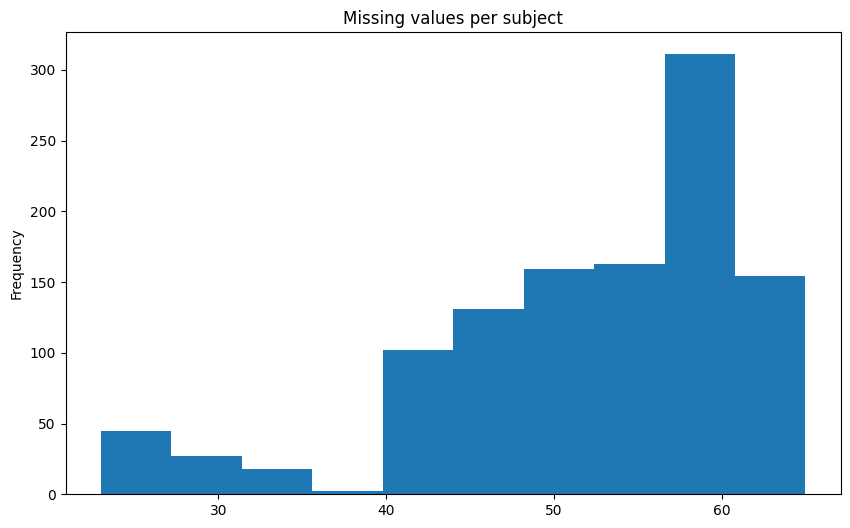

In [61]:
nan_values = ASD_phenotypic.T.isna().sum()

# Filter columns with NaN values
subjects_with_nan = nan_values[nan_values > 0]

print("Max missing values encountered for a subject: " +str(max(subjects_with_nan)))
subjects_with_nan.plot(kind='hist', bins=10, figsize=(10,6), title='Missing values per subject')
plt.show()


Let's have a look on the general statistics for the numerical attributes.

In [56]:
ASD_phenotypic.describe()

,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,...,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
count,1112.000000,1112.000000,1040.000000,1112.000000,1112.000000,...,55.000000,55.000000,1112.000000,100.000000,94.000000
mean,50752.684353,1.515288,0.639423,17.048864,1.147482,...,8.763636,9.890909,1.312050,12.951700,20.519255
std,447.680666,0.499991,0.828849,8.036419,0.354745,...,2.821634,2.753266,0.463539,2.193555,5.244446
min,50002.000000,1.000000,0.000000,6.470000,1.000000,...,4.000000,1.000000,1.000000,8.290000,6.530000
25%,50354.750000,1.000000,0.000000,11.658575,1.000000,...,7.000000,8.000000,1.000000,11.265000,17.422500
50%,50724.500000,2.000000,0.000000,14.660000,1.000000,...,9.000000,10.000000,1.000000,12.945000,19.945000
75%,51153.250000,2.000000,1.000000,20.085000,1.000000,...,10.500000,12.000000,2.000000,14.462500,22.645000
max,51607.000000,2.000000,4.000000,64.000000,2.000000,...,15.000000,16.000000,2.000000,17.940000,35.430000


We need to handle missing values. But how?
Is really necessary to fullfill all of them? Can we maybe make some feature selection previously?


In [57]:
'''f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ASD_phenotypic.drop('DX_GROUP',axis = 1).corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.2f',
            ax=ax,
            vmin=-1, 
            vmax=1,
            cmap = "coolwarm")
plt.show()'''

'f,ax = plt.subplots(figsize=(10, 8))\nsns.heatmap(ASD_phenotypic.drop(\'DX_GROUP\',axis = 1).corr(), \n            annot=True, \n            linewidths=.5, \n            fmt= \'.2f\',\n            ax=ax,\n            vmin=-1, \n            vmax=1,\n            cmap = "coolwarm")\nplt.show()'

Drop attribute if:
- Only unique values
- Only missing values